# 내가 새로 배운 내용
1. pandas.DataFrame.rolling(window:int)
    * .mean() 이동평균
    * .std() 이동표준편차
2. ADF Test (Augmented Dickey-Fuller Test)
    * 시계열 데이터의 안정성(Stationary)한지 확인, P-value 체크하기
    
3. Stationary 전처리
    * log 취하기
    * Trend 제거
        - rolling.mean() # dropna 해야함
    * Seasonality 제거
        - 1차 차분, (2차 차분, 3차 차분) # dropna 해야함
    * 위 Trend, Seasonality을 제거하는 함수 `statsmodels.tsa.seasonal.seasonal_decompose`
        - decomposition = seasonal_decompose(ts_log)
        - trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
        - seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
        - residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성 (Done!)

In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings('ignore')

# augmented_dickey_fuller test
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

# score(mse, mae, rmse, mape) 
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

# ACFm PACF 그래프 그리기 - ARIMA 의 d,p,q 찾기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ARIMA
from statsmodels.tsa.arima.model import ARIMA

plt.rcParams['figure.figsize'] = 13, 5

data_path = "data/ex4/"

In [18]:
dataset_filepath = os.path.join(data_path,"daily-min-temperatures.csv")
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
df.head()

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


ts1 sample 3 :


Date
1981-01-01    20.7
1981-01-02    17.9
1981-01-03    18.8
Name: Temp, dtype: float64


ts1 is nall? :


Series([], Name: Temp, dtype: float64)

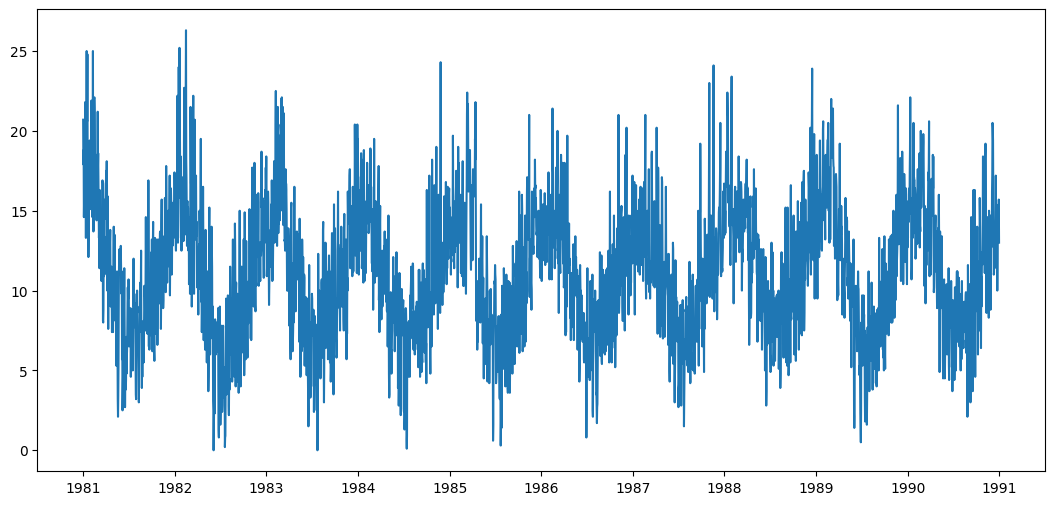

In [11]:
ts1 = df['Temp']  # 우선은 데이터 확인용이니 time series 의 이니셜을 따서 'ts'라고 이름 붙여줍시다!

print("ts1 sample 3 :")
display(ts1.head(3))
print("\nts1 is nall? :")
display(ts1[ts1.isna()])

# 결측치가 있다면 보간해줍니다.
# ts1=ts1.interpolate(method='time')

plt.plot(ts1)

* 이동표준편차, 이동평균 그래프

In [13]:
# 단위값(window_size)기준 이동평균, 이동표준편차가 적용된 그래프 그리기 
# pandas 내장 함수(rolling)로 가능

def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

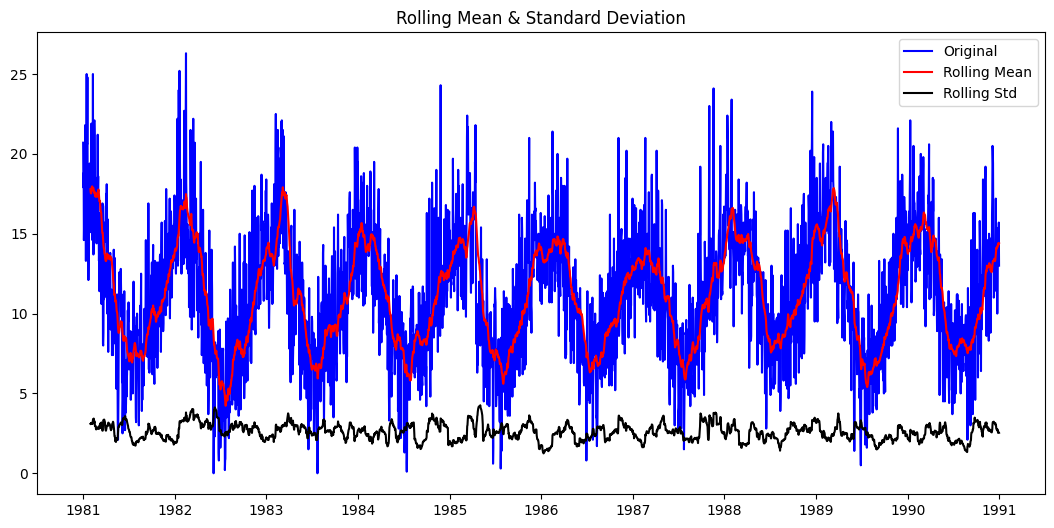

In [14]:
plot_rolling_statistics(ts1, window=30)

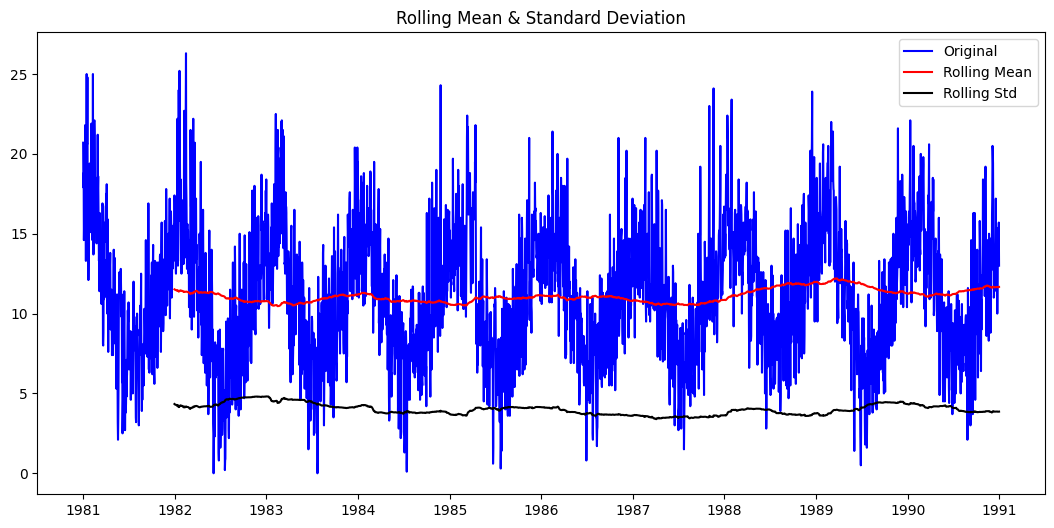

In [15]:
plot_rolling_statistics(ts1, window=365)

airline-passengets sample 3


,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132


ts2 plot


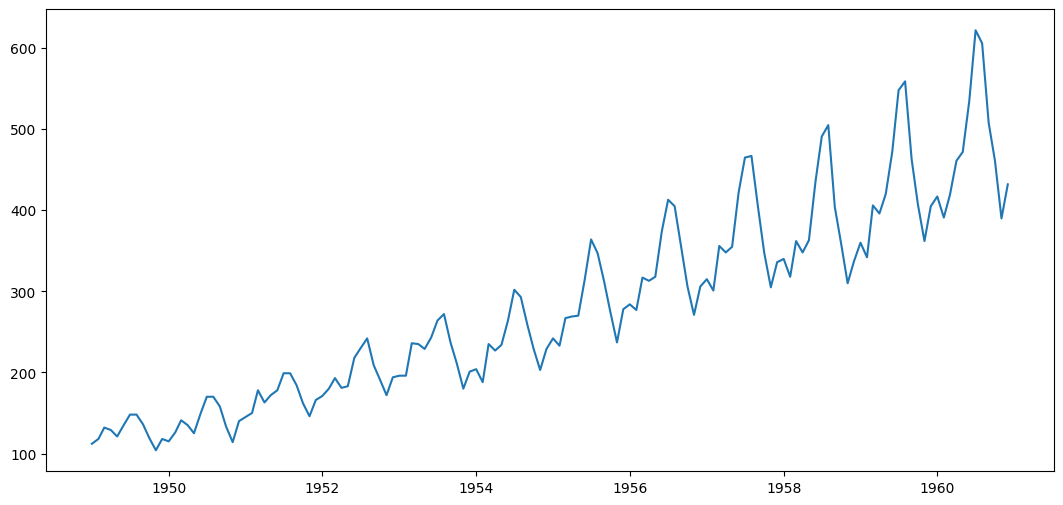

In [23]:
dataset_filepath = dataset_filepath = os.path.join(data_path,"airline-passengers.csv")
df = pd.read_csv(dataset_filepath, index_col='Month', parse_dates=True).fillna(0)  
print("airline-passengets sample 3")
display(df.head(3))
ts2 = df['Passengers']
print("ts2 plot")
plt.plot(ts2)

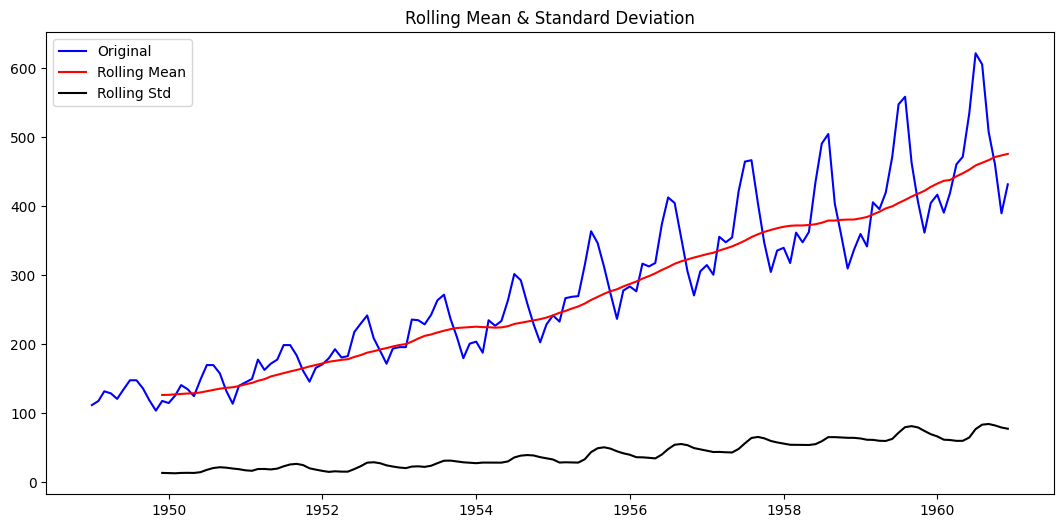

In [24]:
plot_rolling_statistics(ts2, window=12)

* 시계열 데이터가 Stationary 한지 확인

In [30]:
def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [31]:
augmented_dickey_fuller_test(ts1) # p-value = 0.000247

Results of Dickey-Fuller Test:
Test Statistic                   -4.444805
p-value                           0.000247
#Lags Used                       20.000000
Number of Observations Used    3629.000000
Critical Value (1%)              -3.432153
Critical Value (5%)              -2.862337
Critical Value (10%)             -2.567194
dtype: float64


In [32]:
augmented_dickey_fuller_test(ts2) # p-value = 0.99188

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


* 전처리1 ( Stationary 하기 만들기 )
    - log
    - 추세(trend) 제거

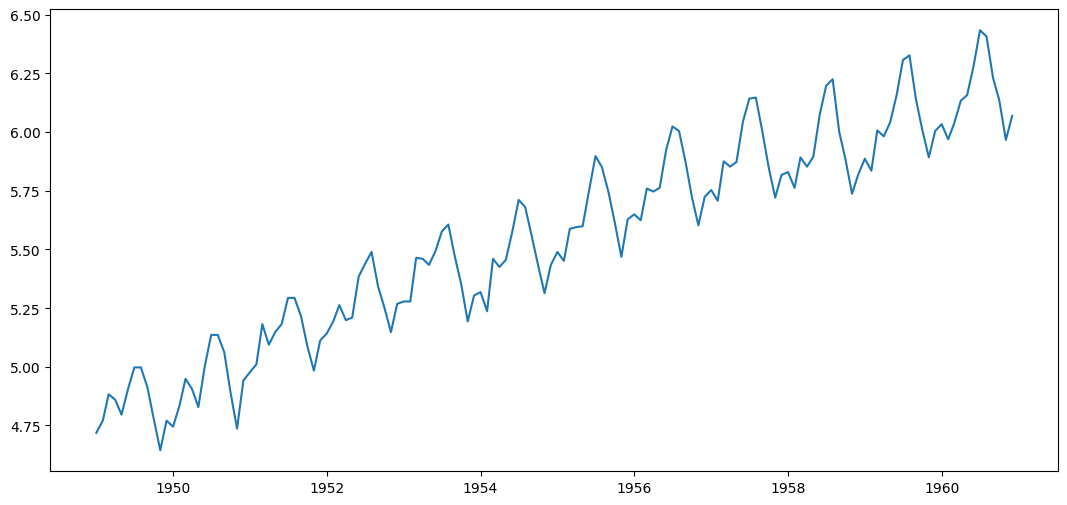

In [33]:
ts_log = np.log(ts2)
plt.plot(ts_log)

In [34]:
augmented_dickey_fuller_test(ts_log) # p-value = 0.422367

Results of Dickey-Fuller Test:
Test Statistic                  -1.717017
p-value                          0.422367
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


* 추세 제거

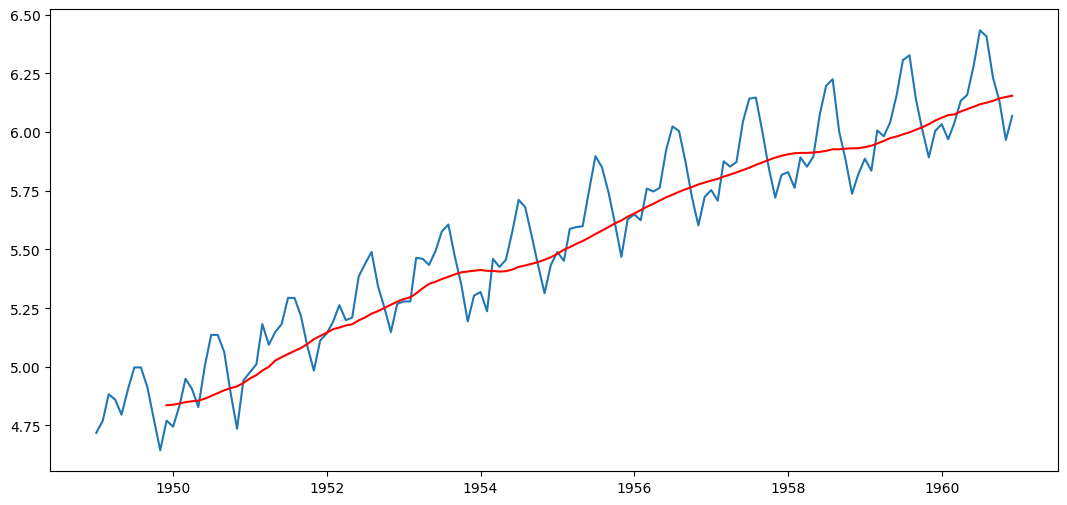

In [36]:
moving_avg = ts_log.rolling(window=12).mean()  # moving average구하기 ( 앞 11개의 데이터 제거 됨 )
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [38]:
ts_log_moving_avg = ts_log - moving_avg
display(ts_log_moving_avg.head())
ts_log_moving_avg.dropna(inplace=True) # rolling 으로 제거된 부분 dropna로 제거
display(ts_log_moving_avg.head())

Month
1949-01-01   NaN
1949-02-01   NaN
1949-03-01   NaN
1949-04-01   NaN
1949-05-01   NaN
Name: Passengers, dtype: float64

Month
1949-12-01   -0.065494
1950-01-01   -0.093449
1950-02-01   -0.007566
1950-03-01    0.099416
1950-04-01    0.052142
Name: Passengers, dtype: float64

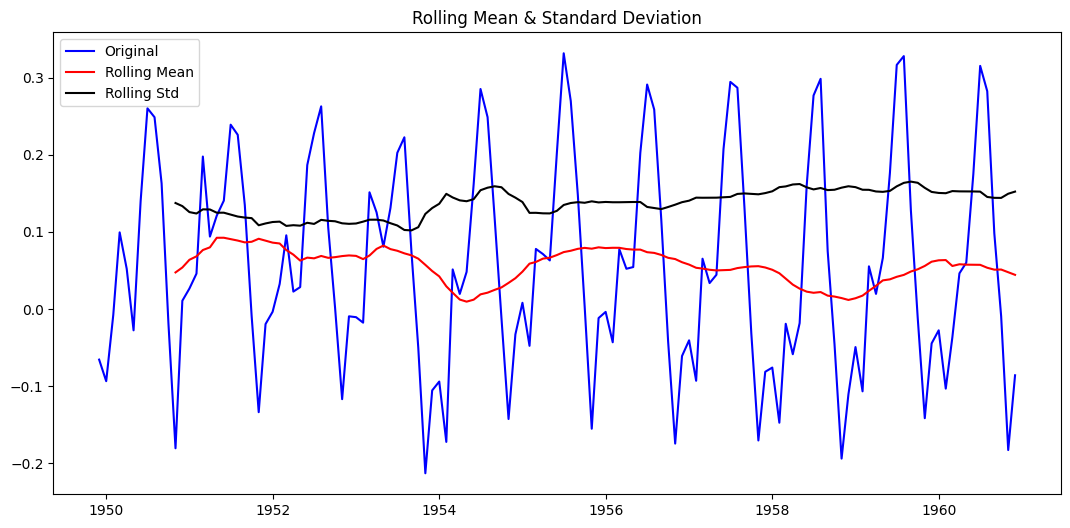

Results of Dickey-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [40]:
plot_rolling_statistics(ts_log_moving_avg)
augmented_dickey_fuller_test(ts_log_moving_avg) # p-value = 0.022235

* 차분(Differencing) - 계절성(Seasonality) 상쇄하기

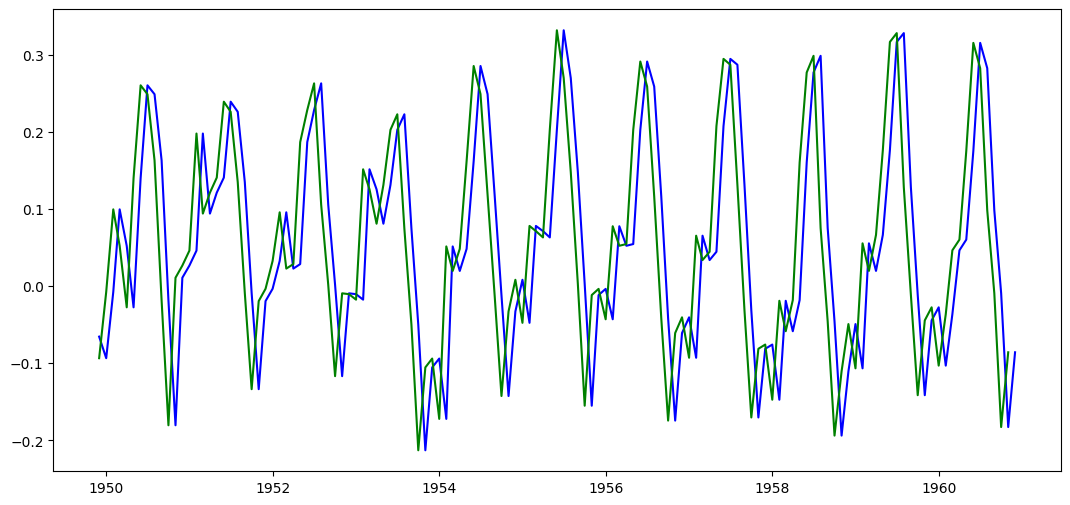

In [41]:
# 1차 차분 그래프 를 생성하여 Seasonality 를 상쇄
# 필요한 경우 2차, 3차 차분을 적용하는 것이 좋을 수도 있음
ts_log_moving_avg_shift = ts_log_moving_avg.shift(-1) # -1 씩 옮겨진 그래프 

plt.plot(ts_log_moving_avg, color='blue') 
plt.plot(ts_log_moving_avg_shift, color='green')

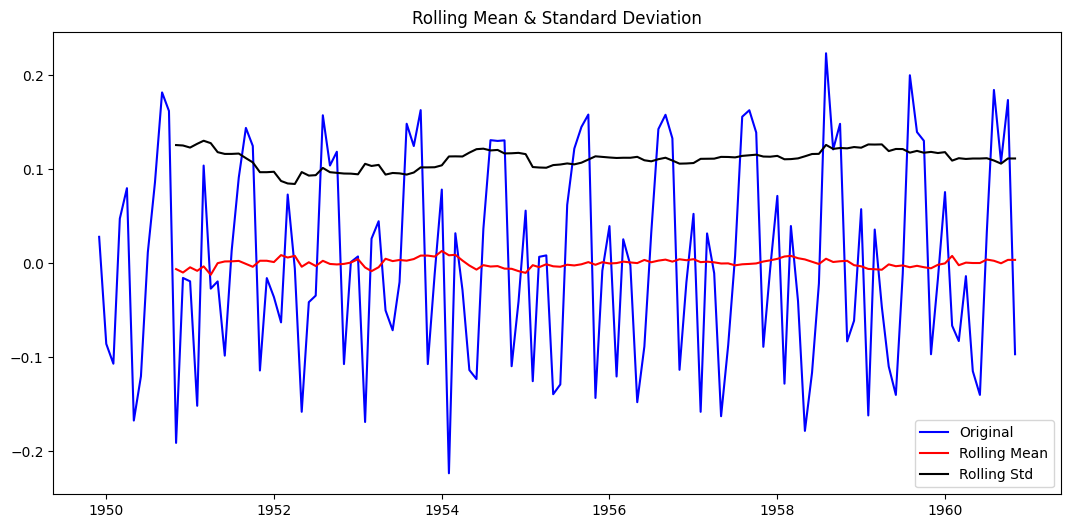

Results of Dickey-Fuller Test:
Test Statistic                  -3.912981
p-value                          0.001941
#Lags Used                      13.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64


In [44]:
ts_log_moving_avg_diff = ts_log_moving_avg - ts_log_moving_avg_shift # 이전스탭의 변화량
ts_log_moving_avg_diff.dropna(inplace=True)
plot_rolling_statistics(ts_log_moving_avg_diff)
augmented_dickey_fuller_test(ts_log_moving_avg_diff) # p-value = 0.001941

* 시계열 분해(Time series decomposition)

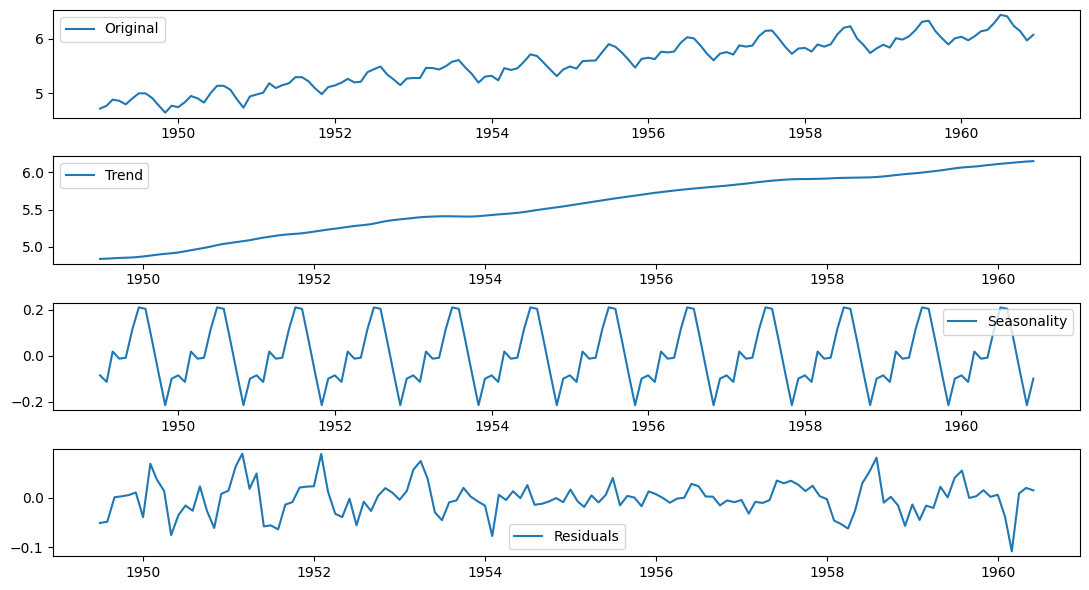

In [46]:
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

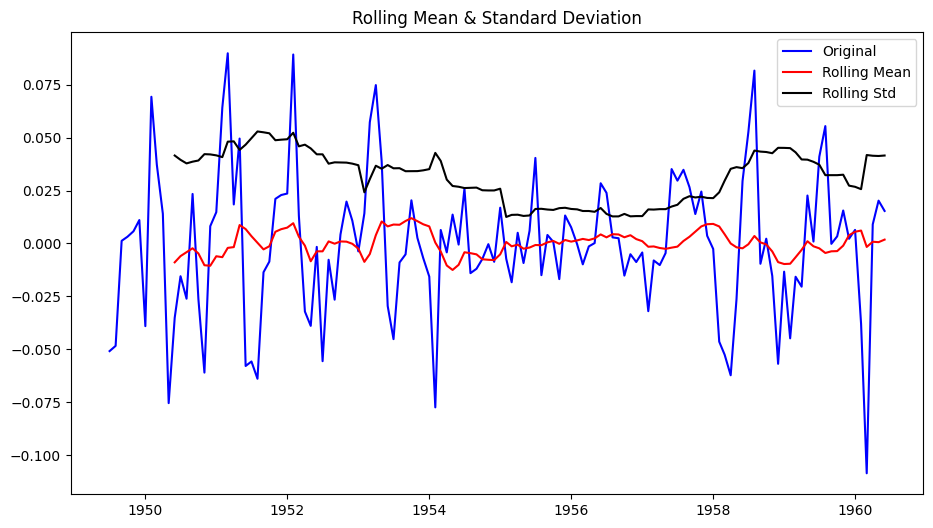

Results of Dickey-Fuller Test:
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


In [48]:
plot_rolling_statistics(residual)
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

# ARIMA(Autoregressive Integrated Moving Average)

ARIMA는 AR, I, MA로 나뉜다.
* AR(Autoregressive) - 자기회귀 # Residual
* I(Integration) - 차분 누적 # Seasonality
* MA(Moving Average) - 이동평균 # Trend

이 3개의 모델을 ARIMA는 모두 고려한다
</br>
* ARIMA의 모수에는 3가지가 있다.
    - p : 자기회귀 모형(AR)의 시차
    - d : 차분 누적(I) 횟수
    - q : 이동평균 모형(MA)의 시차
    
p 와 q 는 일반적으로 p + q < 2, p * q = 0 인 값을 사용합니다. 왜냐하면 일반적으로 `MA` 이거나 `AR` 이기 때문입니다.

ACF 는 점차 감소하면서 AR(1)과 유사해지고있습니다. 적합한 q 값이 없어보입니다.

1. ACF(Autocorrelation Function) -  현재시점과 p 만큼 떨어졌을 때의 상관도
    * 시차(lag)에 따른 관측치들 사이의 관련성을 측정하는 함수
    * 주어진 시계열의 현재 값이 과거값과 어떻게 상관되는지 설명함.
    * ACF plot에서 X 축은 상관 계수를 나타냄, y축은 시차 수를 나타냄
2. PACF(Partial Autocorrelation Function)
    * 다른 관측치의 영향력을 배제하고 두 시차의 관측치 간 관련성을 측정하는 함수
    * k 이외의 모든 시차를 갖는 관측치의 영향력을 배제한 가운데 특정 두 관측치가 얼마나 관련이 있는지 나타내는 척도.

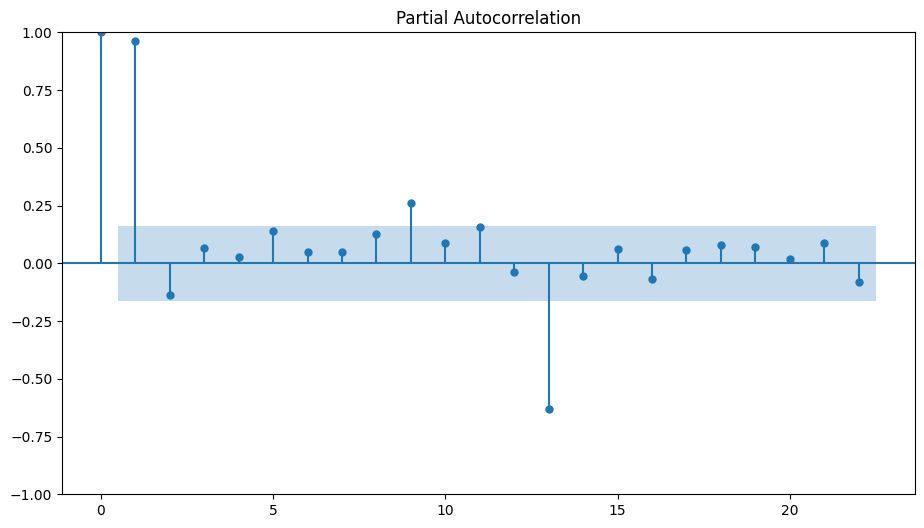

In [54]:
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

PACF 그래프를 보면 p=2 가되면서 0에 가까워지기 떄문에 p=1이 가장 적합해 보입니다.

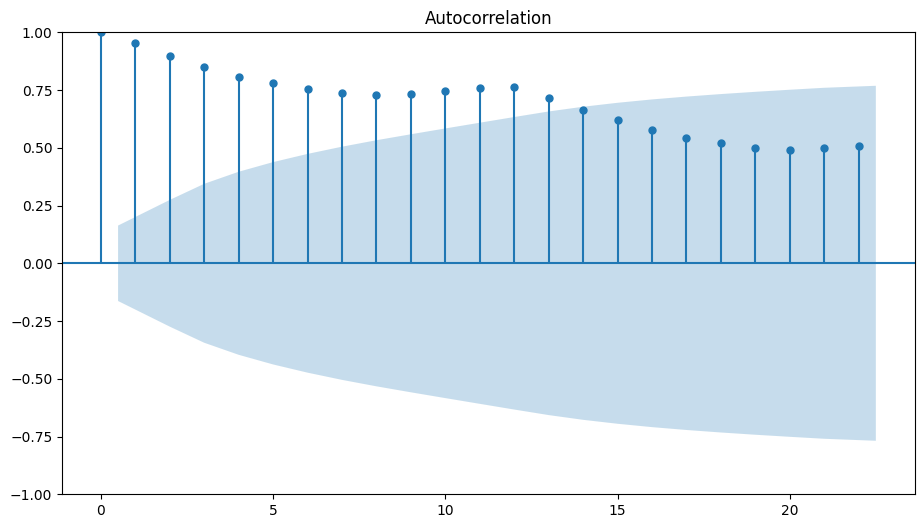

In [52]:
plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plt.show()

ACF 는 점차 감소하면서 AR(1) 모델과 유사해 보입니다. q에 적합한 값은 정할 수 없어 보입니다.

MA 를 고려할 필요가 없다면 q=0 라고 할 수 있습니다. 하지만 q값을 바꿔가며 넣어도 됩니다.

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


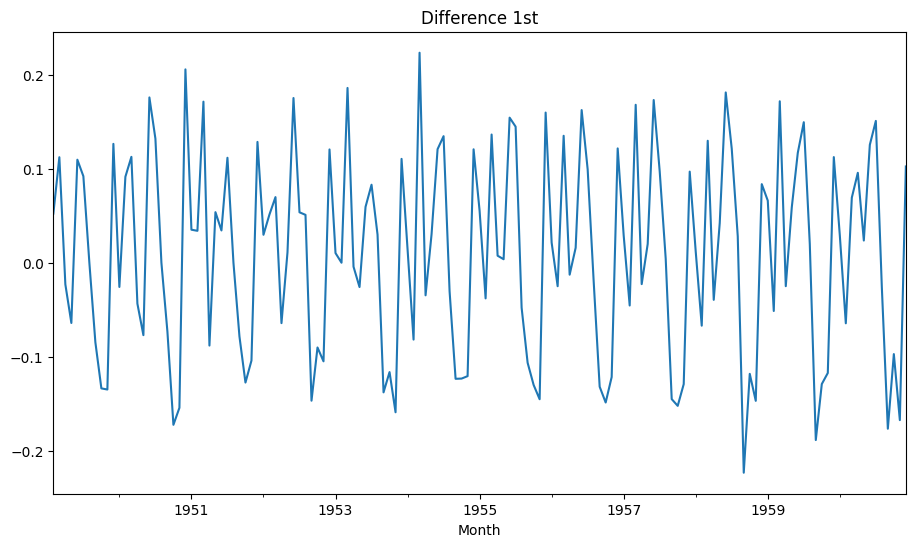

In [55]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -8.196629e+00
p-value                        7.419305e-13
#Lags Used                     1.300000e+01
Number of Observations Used    1.280000e+02
Critical Value (1%)           -3.482501e+00
Critical Value (5%)           -2.884398e+00
Critical Value (10%)          -2.578960e+00
dtype: float64


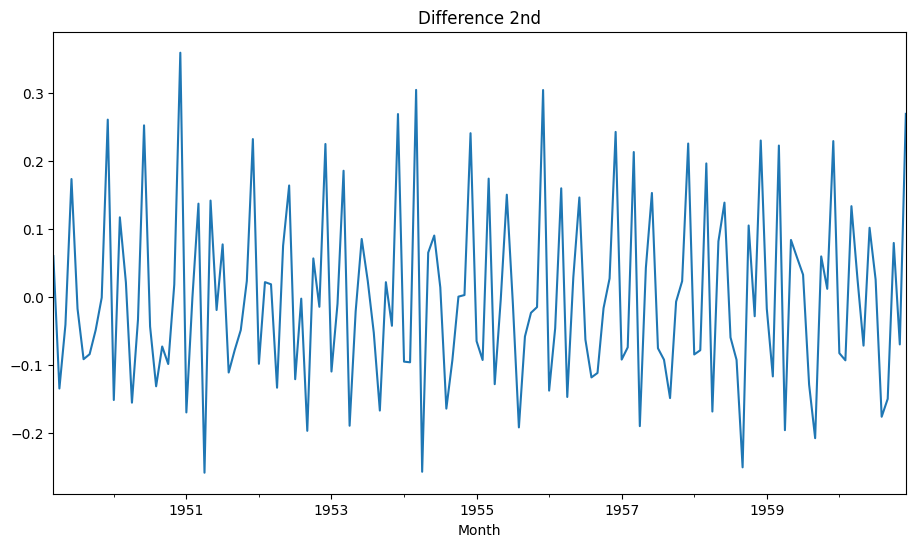

In [56]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

* TTS

뒤에서 10%의 데이터를 test 데이터셋으로 사용하여 test를 예측

Month
1949-01-01    4.718499
1949-02-01    4.770685
Name: Passengers, dtype: float64
train_data.shape :  (129,)
test_data.shape :  (15,)


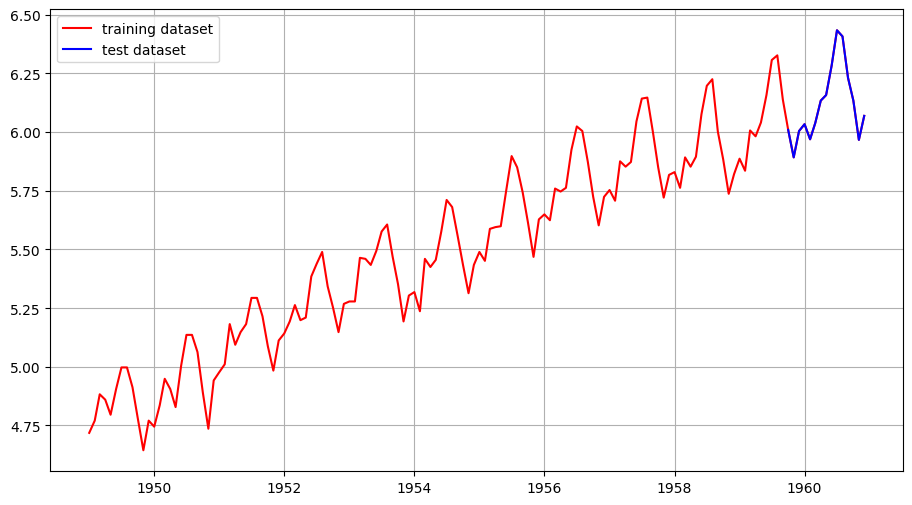

In [60]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]

print(ts_log[:2])
print("train_data.shape : ",train_data.shape)
print("test_data.shape : ",test_data.shape)

plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

* modeling
    1. ARIMA 모델(train_data, order=(p,d,q))
    2. fit
    3. predict, forecast(len(test_data), alpha=0.05) # alpha는 신뢰도 
    

In [61]:
# Build Model
model = ARIMA(train_data, order=(14, 1, 0)) # 모수는 이전 그래프를 참고 
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  129
Model:                ARIMA(14, 1, 0)   Log Likelihood                 219.973
Date:                Thu, 13 Apr 2023   AIC                           -409.945
Time:                        02:45:40   BIC                           -367.165
Sample:                    01-01-1949   HQIC                          -392.563
                         - 09-01-1959                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2709      0.081     -3.344      0.001      -0.430      -0.112
ar.L2         -0.0111      0.108     -0.102      0.918      -0.223       0.200
ar.L3         -0.0028      0.046     -0.060      0.9

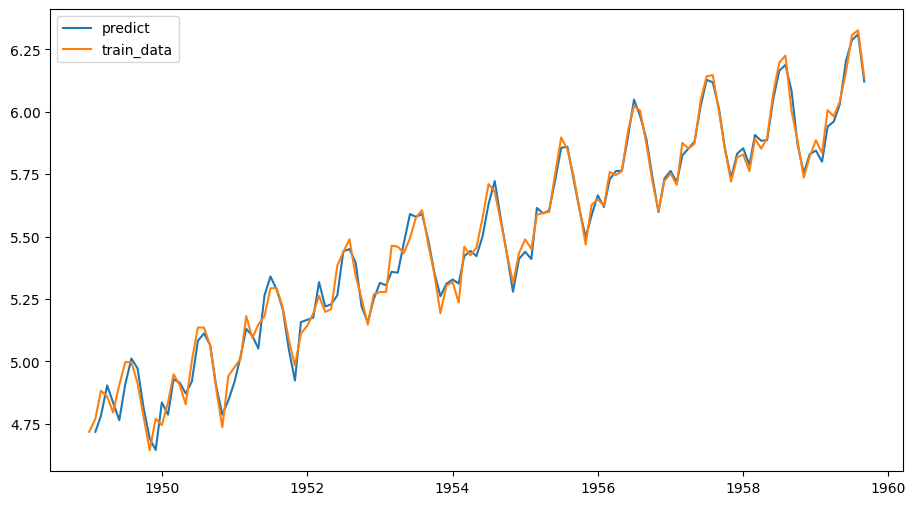

In [62]:
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])
plt.plot(fitted_m, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()

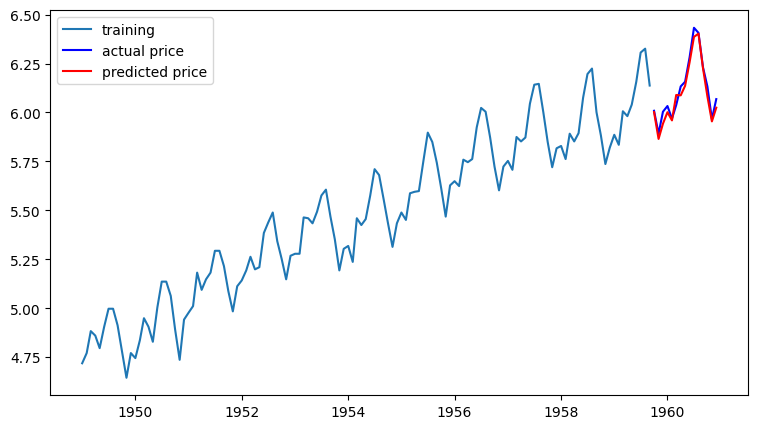

In [63]:
model = ARIMA(train_data, order=(14, 1, 0))  # p값을 14으로 테스트
fitted_m = model.fit() 
fc= fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [64]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  248.4434997063531
MAE:  13.144304444960323
RMSE:  15.76209058806455
MAPE: 2.89%


# Task - 주식데이터

## setup

In [167]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings('ignore')

# augmented_dickey_fuller test
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

# score(mse, mae, rmse, mape) 
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

# ACFm PACF 그래프 그리기 - ARIMA 의 d,p,q 찾기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ARIMA
from statsmodels.tsa.arima.model import ARIMA

plt.rcParams['figure.figsize'] = 13, 4

data_path = "data/ex4/"

## data

In [150]:
dataset_filepath = os.path.join(data_path,"samsung.csv")
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
print(len(df))
display(df.head(15))

1230


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-04-13,49600.0,50180.0,49400.0,49800.0,43256.636719,10278300
2018-04-16,50320.0,50600.0,49860.0,50340.0,43725.679688,7877450
2018-04-17,50240.0,50540.0,49820.0,49980.0,43412.984375,7772000
2018-04-18,51000.0,51360.0,50580.0,51360.0,44611.664063,13462600
2018-04-19,52000.0,52980.0,51540.0,52780.0,45845.082031,17190550
2018-04-20,51800.0,52260.0,51420.0,51620.0,44837.496094,11761000
2018-04-23,51000.0,52080.0,51000.0,51900.0,45080.703125,11619000
2018-04-24,51840.0,51860.0,50080.0,50460.0,43829.917969,15770300
2018-04-25,49220.0,50500.0,49220.0,50400.0,43777.792969,16614600


In [168]:
dataset_filepath = os.path.join(data_path,"apple.csv")
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
print(len(df))
display(df.head(15))

1257


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-04-13,43.695000,43.959999,43.462502,43.682499,41.643444,100497200
2018-04-16,43.757500,44.047501,43.707500,43.955002,41.903236,86313600
2018-04-17,44.122501,44.735001,44.102501,44.560001,42.479996,106421600
2018-04-18,44.452499,44.705002,44.220001,44.459999,42.384659,83018000
2018-04-19,43.439999,43.847500,43.165001,43.200001,41.183472,139235200
2018-04-20,42.650002,42.805000,41.357498,41.430000,39.496090,261964400
2018-04-23,41.707500,41.730000,41.022499,41.310001,39.381699,146062000
2018-04-24,41.417500,41.582500,40.305000,40.735001,38.833538,134768000
2018-04-25,40.654999,41.355000,40.602501,40.912498,39.002747,113528400


In [169]:
ts = df['Close'] # 종가
ts[ts.isna()] # 결측치없음

Series([], Name: Close, dtype: float64)

## 전처리
### log

Results of Dickey-Fuller Test:
Test Statistic                   -0.888373
p-value                           0.791777
#Lags Used                        1.000000
Number of Observations Used    1255.000000
Critical Value (1%)              -3.435571
Critical Value (5%)              -2.863846
Critical Value (10%)             -2.567998
dtype: float64


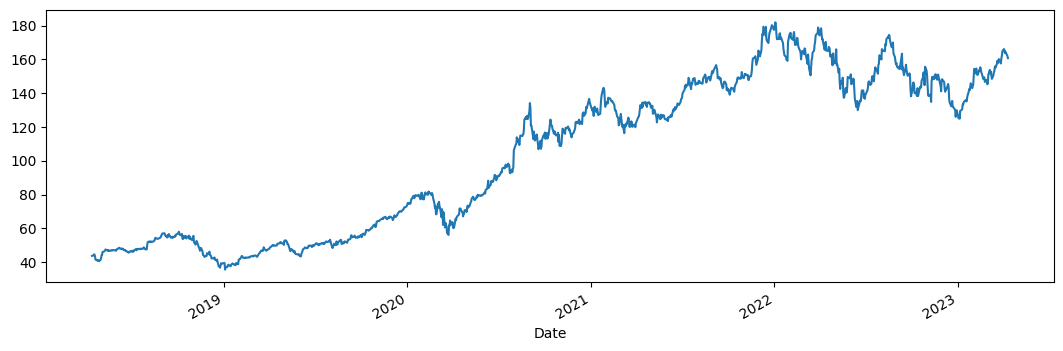

In [170]:
ts.plot()
augmented_dickey_fuller_test(ts)

<Axes: xlabel='Date'>

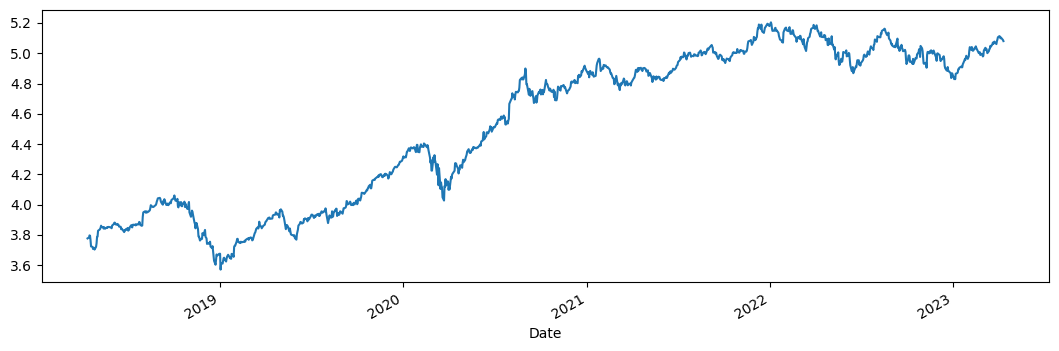

In [171]:
ts_log = np.log(ts)
ts_log.plot()

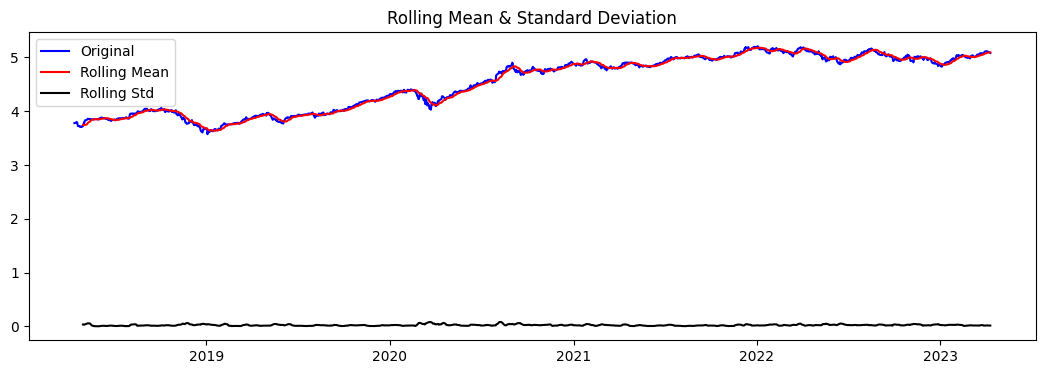

Results of Dickey-Fuller Test:
Test Statistic                   -1.259160
p-value                           0.647643
#Lags Used                        9.000000
Number of Observations Used    1247.000000
Critical Value (1%)              -3.435605
Critical Value (5%)              -2.863861
Critical Value (10%)             -2.568005
dtype: float64


In [172]:
plot_rolling_statistics(ts_log, window=12)
augmented_dickey_fuller_test(ts_log)

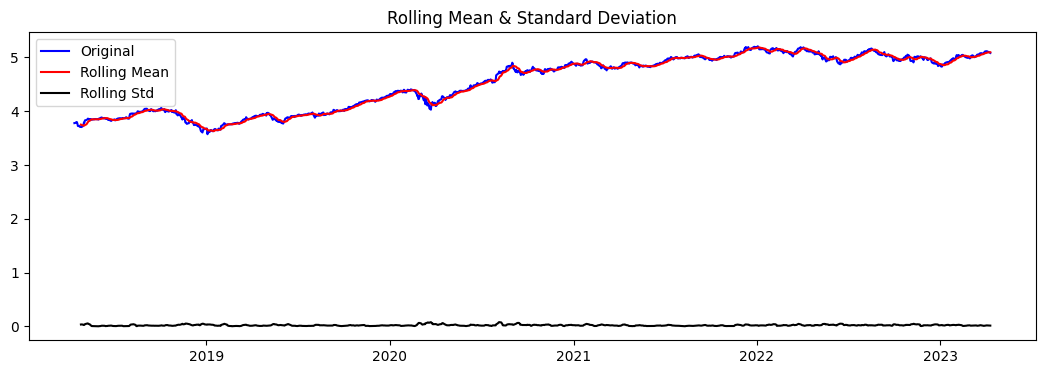

Results of Dickey-Fuller Test:
Test Statistic                   -1.259160
p-value                           0.647643
#Lags Used                        9.000000
Number of Observations Used    1247.000000
Critical Value (1%)              -3.435605
Critical Value (5%)              -2.863861
Critical Value (10%)             -2.568005
dtype: float64


In [173]:
plot_rolling_statistics(ts_log, window=10)
augmented_dickey_fuller_test(ts_log)

### seasonality, trend

In [174]:
#시계열 분해 (Time Series Decomposition)
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 5) 
residual = decomposition.resid
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.548595e+01
p-value                        2.520721e-28
#Lags Used                     1.600000e+01
Number of Observations Used    1.236000e+03
Critical Value (1%)           -3.435652e+00
Critical Value (5%)           -2.863881e+00
Critical Value (10%)          -2.568016e+00
dtype: float64


In [175]:
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 10) 
residual = decomposition.resid
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.476193e+01
p-value                        2.394815e-27
#Lags Used                     1.400000e+01
Number of Observations Used    1.232000e+03
Critical Value (1%)           -3.435669e+00
Critical Value (5%)           -2.863889e+00
Critical Value (10%)          -2.568021e+00
dtype: float64


In [176]:
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 20) 
residual = decomposition.resid
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.023944e+01
p-value                        4.792423e-18
#Lags Used                     2.100000e+01
Number of Observations Used    1.215000e+03
Critical Value (1%)           -3.435744e+00
Critical Value (5%)           -2.863922e+00
Critical Value (10%)          -2.568038e+00
dtype: float64


## TTS

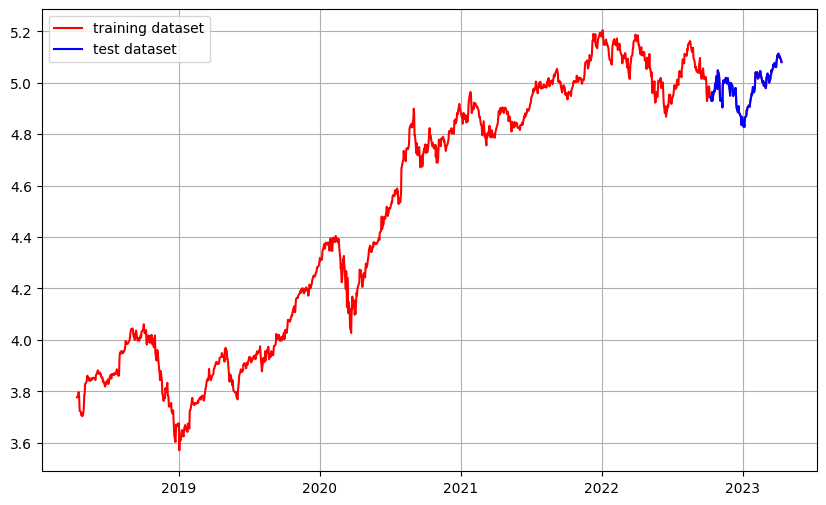

In [177]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

## ARIMA order

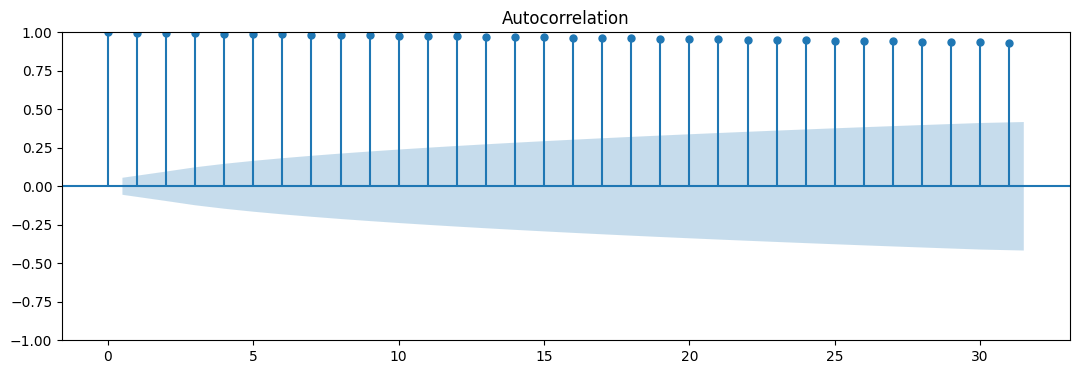

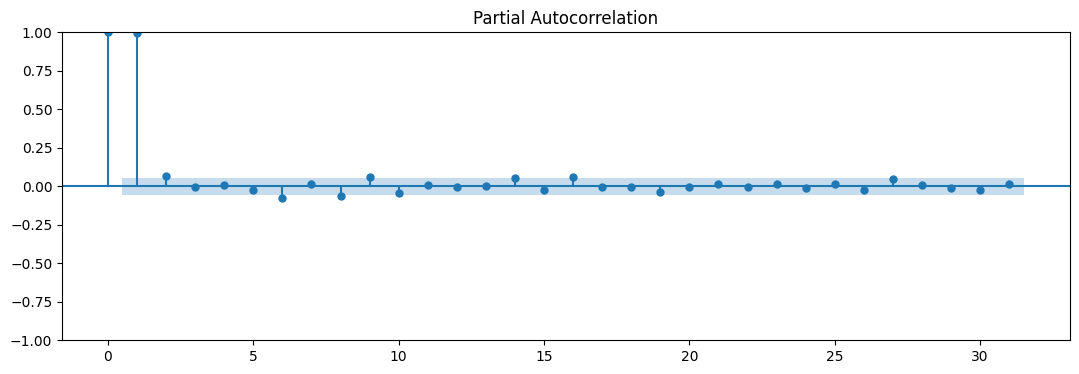

In [178]:
plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.100694e+01
p-value                        6.468472e-20
#Lags Used                     8.000000e+00
Number of Observations Used    1.247000e+03
Critical Value (1%)           -3.435605e+00
Critical Value (5%)           -2.863861e+00
Critical Value (10%)          -2.568005e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.546236e+01
p-value                        2.695485e-28
#Lags Used                     1.700000e+01
Number of Observations Used    1.237000e+03
Critical Value (1%)           -3.435647e+00
Critical Value (5%)           -2.863879e+00
Critical Value (10%)          -2.568015e+00
dtype: float64


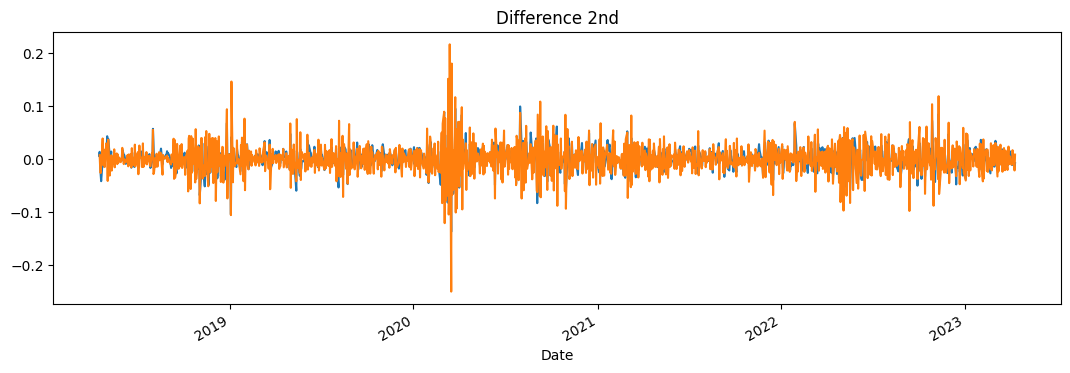

In [179]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

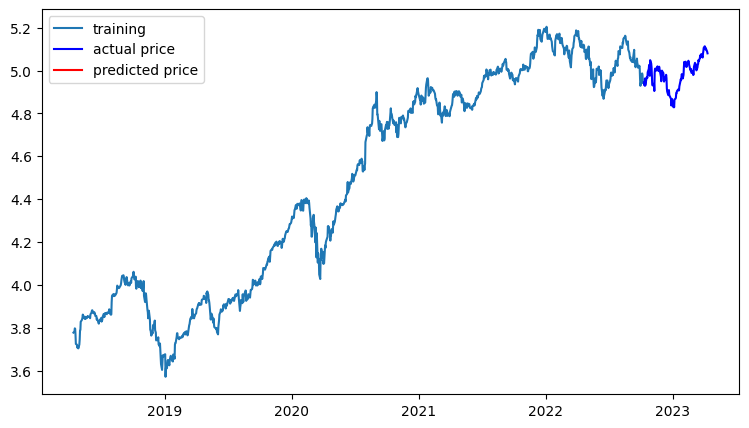

MSE:  131.1580258208888
MAE:  9.571930859188432
RMSE:  11.452424451656025
MAPE: nan%


In [180]:
model = ARIMA(train_data, order=(5, 0, 2)) 
fitted_m = model.fit() 
fc= fitted_m.forecast(len(test_data), alpha=0.05) 
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index) 

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))